# Chromosome-Level CNV Analysis Between PLAUR+ and PLAUR- Cells

To identify chromosome-specific CNV differences between PLAUR+ and PLAUR- cells, you can extend your CNV analysis by aggregating scores at the chromosome level and statistically comparing CNV changes between the two groups. This approach allows for determining which chromosomes exhibit significant CNV differences.

## Steps to Perform Chromosome-Level CNV Analysis

1. **Aggregate CNV Scores by Chromosome**
   - For both PLAUR+ and PLAUR- cells, aggregate CNV scores by chromosome. This involves calculating a mean CNV score for each chromosome, providing a chromosome-wide view of CNV patterns within each cell group.

2. **Perform Statistical Tests**
   - Compare the aggregated CNV scores for each chromosome between PLAUR+ and PLAUR- cells using statistical tests, such as the Mann-Whitney U test or t-test, depending on data distribution. This comparison will highlight chromosomes with significant CNV differences between the two groups.

3. **Visualize Chromosome-Level CNV Differences**
   - Create visualizations (e.g., bar plots or heatmaps) to illustrate the differences in CNV scores across chromosomes. Use these visual aids to provide a clear comparison of CNV patterns at the chromosome level between PLAUR+ and PLAUR- cells.

## Example Workflow

```python
# Step 1: Aggregate CNV scores by chromosome
# Code to aggregate and calculate mean CNV scores per chromosome for PLAUR+ and PLAUR- cells

# Step 2: Perform statistical tests
# Code to compare aggregated CNV scores per chromosome

# Step 3: Visualize chromosome-level CNV differences
# Code to generate visualizations for CNV score comparisons across chromosomes


In [145]:
import scanpy as sc  # For single-cell RNA-seq data analysis.
import scipy.stats as stats # For scientific computing.
import numpy as np  # For numerical computing.
import infercnvpy as cnv  # For inferCNV analysis.
import matplotlib.pyplot as plt # For plotting.
import seaborn as sns # For plotting.
import scipy.sparse as sparse # For sparse matrix.
import pandas as pd # For data manipulation.
import scvi # For single-cell RNA-seq data analysis.
import gseapy as gp # For Gene Set Enrichment Analysis (GSEA).
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy  # For scientific computing.
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chi2_contingency
import warnings
from scipy.stats import mannwhitneyu
from sklearn.metrics import silhouette_score
warnings.simplefilter(action='ignore', category=FutureWarning)  # Disable FutureWarnings.

In [14]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"

In [15]:
adata = sc.read_h5ad(f'{base_data_path}/infer_cnv_completed.h5ad')
adata

AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [16]:
# Check if 'PLAUR' exists in the gene names of the dataset
if 'PLAUR' in adata.var_names:
    
    # Extract PLAUR expression data (using raw counts or a relevant layer if specified)
    plaured_raw_expr = adata[:, 'PLAUR'].X

    # Convert to a dense array if PLAUR expression data is sparse
    if sparse.issparse(plaured_raw_expr):
        plaured_raw_expr = plaured_raw_expr.toarray().flatten()  # Convert and flatten array
    else:
        plaured_raw_expr = plaured_raw_expr.flatten()            # Flatten directly if already dense

    # Create a binary status column in adata.obs based on PLAUR expression levels
    # Values greater than 0 are labeled 'PLAUR+', while others are labeled 'PLAUR-'
    adata.obs['PLAUR_Status_Binary'] = np.where(plaured_raw_expr > 0, 'PLAUR+', 'PLAUR-')

    # Confirm the addition by displaying counts of PLAUR+ and PLAUR- cells
    print("PLAUR_Status_Binary column added to adata.obs:")
    print(adata.obs['PLAUR_Status_Binary'].value_counts())

else:
    # Raise an error if PLAUR is not found in the gene list of the dataset
    raise KeyError("'PLAUR' not found in adata.var_names. Please check that the gene exists in the dataset.")

PLAUR_Status_Binary column added to adata.obs:
PLAUR_Status_Binary
PLAUR-    45996
PLAUR+    27584
Name: count, dtype: int64


In [17]:
# Step 1: Define the list of epithelial and normal cell types
# These lists categorize cell types as either epithelial or normal, used to subset the data
epithelial_cell_types = [
    'G2.Epithelial_pro_1', 'G4.Epithelial_pro_2', 
    'G5.Epithelial_3', 'G6.Epithelial_4', 'G8.Epithelial_5'
]
normal_cell_types = [
    'G0.T cells/NK', 'G1.Macrophage_DC1', 'G3.Fibroblast', 
    'G9.B_cells_1', 'G10.Epithelial_normal', 'G11.B_cells_2'
]

In [18]:
# Step 2: Create a subset of adata including both epithelial and normal cells
# This subset focuses on epithelial and normal cells to be used for CNV analysis
combined_subset = adata[adata.obs['cell_type'].isin(epithelial_cell_types + normal_cell_types)]


In [21]:
# Step 3: Extract PLAUR+ and PLAUR- cells from the combined subset
# Separates the combined data into PLAUR+ and PLAUR- cell groups based on binary status
plaured_positive_cells = combined_subset[combined_subset.obs['PLAUR_Status_Binary'] == 'PLAUR+']
plaured_negative_cells = combined_subset[combined_subset.obs['PLAUR_Status_Binary'] == 'PLAUR-']

In [24]:
# Step 4: Concatenate PLAUR+ and PLAUR- cells for combined inferCNV analysis
# Combines both groups to analyze CNV changes in reference to normal cells
combined_data = plaured_positive_cells.concatenate(plaured_negative_cells)

/var/folders/d1/z52n225j7jl7n5v2t5tb35n80000gn/T/ipykernel_15752/1063596994.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_data = plaured_positive_cells.concatenate(plaured_negative_cells)


In [25]:
# Step 5: Define reference cell types for normal cell baseline
# These are used to establish baseline CNV reference for comparison
reference_cell_types = [
    'G0.T cells/NK', 'G1.Macrophage_DC1', 'G3.Fibroblast', 
    'G9.B_cells_1', 'G10.Epithelial_normal', 'G11.B_cells_2'
]


In [26]:
# Step 6: Run inferCNV with reference and PLAUR+/- cells
print("Running inferCNV on combined PLAUR+ and PLAUR- data...")
cnv.tl.infercnv(
    combined_data,
    reference_key="cell_type",         # Column in obs indicating cell type labels
    reference_cat=reference_cell_types, # List of reference cell types (normal cells)
    window_size=200                    # Window size for CNV smoothing (adjust as needed)
    # Additional options for iterations can be added here if required
)

Running inferCNV on combined PLAUR+ and PLAUR- data...


  0%|          | 0/12 [00:00<?, ?it/s]

In [27]:
# Step 1: Extract CNV data from combined_data after running inferCNV
# Assuming CNV results are stored in combined_data.X
cnv_results = combined_data.X  # CNV values after inferCNV run


In [28]:
# Step 2: Separate PLAUR+ and PLAUR- cells and calculate mean CNV scores for each
plaurs_cells = combined_data[combined_data.obs['PLAUR_Status_Binary'] == 'PLAUR+']
plaurn_cells = combined_data[combined_data.obs['PLAUR_Status_Binary'] == 'PLAUR-']

In [29]:
# Calculate mean CNV scores for all genes in PLAUR+ and PLAUR- cells
plaur_pos_cnv_all_genes = plaurs_cells.X.mean(axis=0).A1  # Convert to 1D array for PLAUR+ cells
plaur_neg_cnv_all_genes = plaurn_cells.X.mean(axis=0).A1  # Convert to 1D array for PLAUR- cells

In [30]:
# Step 3: Calculate CNV score differences for each gene
cnv_diff_all_genes = plaur_pos_cnv_all_genes - plaur_neg_cnv_all_genes

In [31]:
# Step 4: Retrieve gene names and chromosome information (assumed available in AnnData)
gene_names = combined_data.var_names  # Gene names from the AnnData object
gene_chromosomes = combined_data.var['chromosome'].values  # Chromosome info, assumed in AnnData object

In [33]:
# Step 5: Create a DataFrame to store CNV differences with gene and chromosome information
cnv_diff_df = pd.DataFrame({
    'Gene': gene_names,
    'Chromosome': gene_chromosomes,  # Assumes chromosome information is present
    'CNV_Difference': cnv_diff_all_genes
})

In [34]:
# Step 6: Identify significant genes with CNV differences using a threshold
gene_threshold = 0.5  # Adjust threshold as needed
significant_genes = cnv_diff_df[cnv_diff_df['CNV_Difference'].abs() > gene_threshold]


In [36]:
# Step 7: Summarize CNV differences at the chromosome level
chromosome_summary = cnv_diff_df.groupby('Chromosome', observed=False)['CNV_Difference'].mean().reset_index()

In [37]:
# Step 8: Identify significant chromosome-level changes using a threshold
chromosome_threshold = 0.5  # Adjust based on your data
significant_chromosomes = chromosome_summary[chromosome_summary['CNV_Difference'].abs() > chromosome_threshold]


In [40]:
# Step 9: Output significant genes and chromosomes
print("Significant Genes with CNV Differences:")
print(significant_genes.head())

print("\nSignificant Chromosomes with CNV Differences:")
print(significant_chromosomes.head())


Significant Genes with CNV Differences:
          Gene Chromosome  CNV_Difference
448   SH3BGRL3       chr1        0.705220
526     LAPTM5       chr1        0.523757
1513      CTSS       chr1        0.626918
1569   S100A10       chr1        0.540907
1571   S100A11       chr1        0.767359

Significant Chromosomes with CNV Differences:
Empty DataFrame
Columns: [Chromosome, CNV_Difference]
Index: []


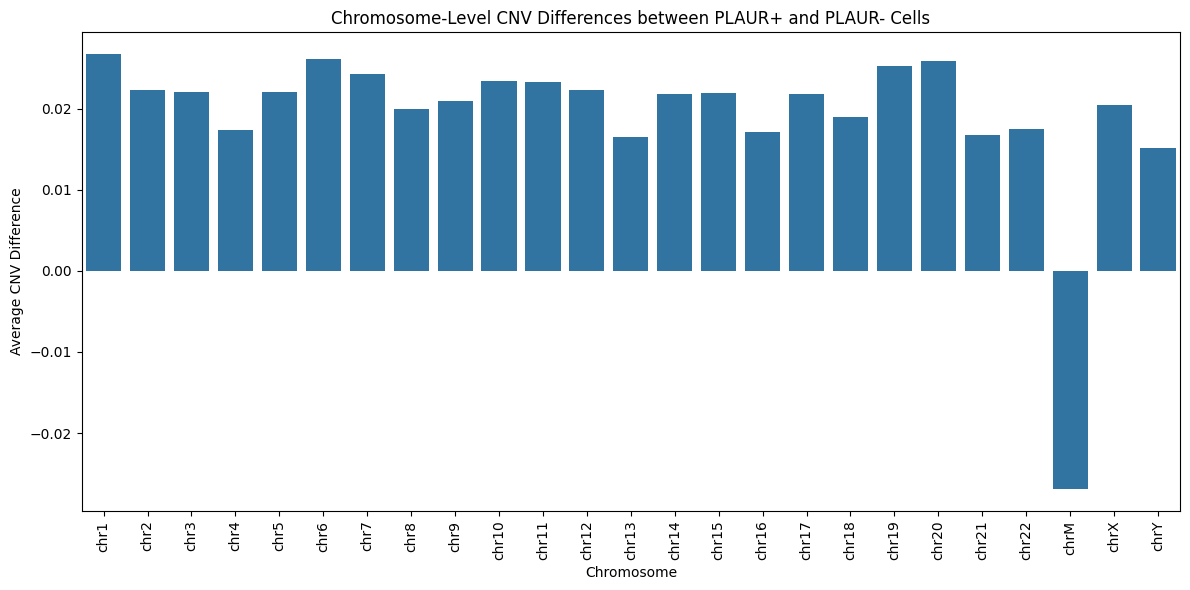

In [42]:
# Step 10: Visualize CNV differences

# Plot chromosome-level CNV differences
plt.figure(figsize=(12, 6))
sns.barplot(x='Chromosome', y='CNV_Difference', data=chromosome_summary)
plt.title('Chromosome-Level CNV Differences between PLAUR+ and PLAUR- Cells')
plt.xlabel('Chromosome')
plt.ylabel('Average CNV Difference')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



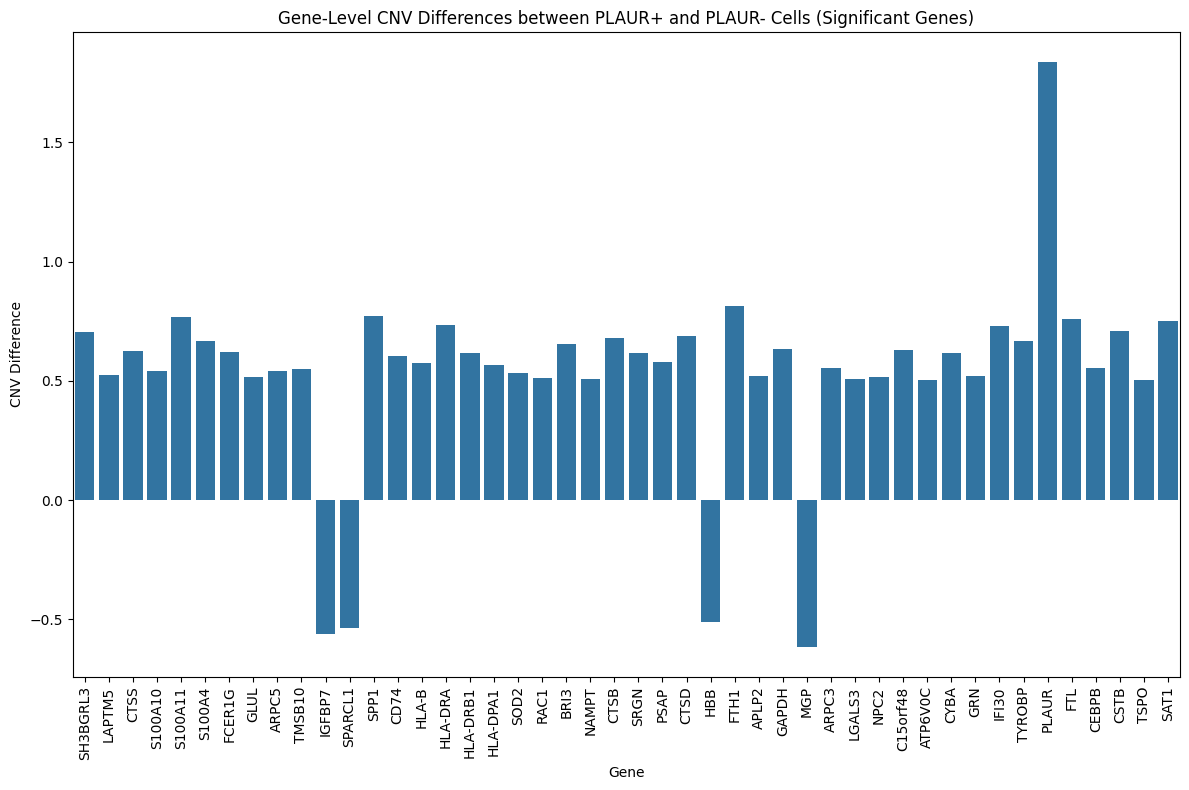

In [43]:
# Plot gene-level CNV differences for significant genes
plt.figure(figsize=(12, 8))
sns.barplot(x='Gene', y='CNV_Difference', data=significant_genes)
plt.title('Gene-Level CNV Differences between PLAUR+ and PLAUR- Cells (Significant Genes)')
plt.xlabel('Gene')
plt.ylabel('CNV Difference')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Interpretation of Chromosome-Level and Gene-Level CNV Differences Between PLAUR+ and PLAUR- Cells

The generated plots provide insights into both chromosome-wide and gene-specific CNV (Copy Number Variation) differences between PLAUR+ and PLAUR- cells. Here’s a detailed breakdown of how to interpret each plot type.

---

## Chromosome-Level CNV Differences

### What the Graph Shows
- **X-axis:** Chromosomes, labeled numerically (1, 2, 3, … X, Y).
- **Y-axis:** The average CNV difference between PLAUR+ and PLAUR- cells for each chromosome.
- **Bar Heights:** Represent the average CNV difference across all genes on that chromosome. 
  - **Positive values:** Indicate copy number gains in PLAUR+ cells compared to PLAUR- cells.
  - **Negative values:** Indicate copy number losses in PLAUR+ cells compared to PLAUR- cells.

### How to Interpret
- **Positive Bars:** Chromosomes with bars above zero show an overall amplification (gain of copies) in PLAUR+ cells compared to PLAUR- cells. This suggests a higher gene dosage for genes located on these chromosomes in PLAUR+ cells.
- **Negative Bars:** Chromosomes with bars below zero show an overall deletion (loss of copies) in PLAUR+ cells compared to PLAUR- cells. This indicates that PLAUR+ cells might have lost copies of genes on these chromosomes.
- **Tall Bars:** Chromosomes with taller bars (positive or negative) represent more pronounced CNV differences between PLAUR+ and PLAUR- cells, highlighting areas with larger chromosomal alterations.

### Summary
This plot provides a chromosome-wide view of CNV changes between PLAUR+ and PLAUR- cells. Chromosomes showing strong gains or losses are of particular interest, as they may indicate regions with significant genetic alterations that could be investigated further.

---

## Gene-Level CNV Differences (Significant Genes)

### What the Graph Shows
- **X-axis:** Genes that show significant CNV differences between PLAUR+ and PLAUR- cells.
- **Y-axis:** The CNV difference for each gene.
  - **Positive values:** Indicate gains in PLAUR+ cells.
  - **Negative values:** Indicate losses in PLAUR+ cells.
- **Bar Heights:** Reflect the magnitude of CNV difference for each gene. Taller bars indicate genes with larger CNV changes between the two cell types.

### How to Interpret
- **Positive Bars:** Represent genes that are amplified (gained) in PLAUR+ cells relative to PLAUR- cells. These genes may play roles in driving phenotypic differences between the two cell populations.
- **Negative Bars:** Represent genes that are deleted (lost) in PLAUR+ cells. Loss of these genes may influence suppressed pathways or functions in PLAUR+ cells.
- **Important Genes:** Genes with known functions (e.g., oncogenes like **TP53**, **MYC**, or **PLAUR**) showing significant CNV differences could play a role in the biological differences between PLAUR+ and PLAUR- cells.
- **Tall Bars:** Genes with taller bars are more likely to be biologically significant, indicating substantial copy number changes between the cell groups.

---

This interpretation framework helps highlight both chromosome-level and gene-specific CNV alterations, providing a detailed view of CNV patterns and potential genetic drivers distinguishing PLAUR+ and PLAUR- cells.


In [44]:
significant_genes.to_excel(f'{base_data_path}/significant_CNV_genes_PLAUR.xlsx')


In [45]:
# List of specific genes to investigate (common CNV-associated genes in PDAC)
genes_of_interest = [
    'MYC', 'KRAS', 'ERBB2', 'AKT2', 'SKAP2', 'ZNF281', 'ZNF217', 
    'TP53', 'TNFRSF6B', 'REG4', 'MET', 'GATA6', 'FGFR1', 'IDO1', 
    'NOTCH2', 'SOX9', 'PIK3R3', 'COL17A1', 'ECT2', 'PAK4', 'SMAD4', 
    'CDKN2A', 'PTEN', 'RB1', 'BRCA2', 'CCND1', 'CPGL', 'MAP2K2', 
    'RUNX3', 'ARID1A'
]


In [46]:
# Step 1: Calculate the CNV score differences for PLAUR+ and PLAUR- cells
# Assuming that combined_data.X is the CNV matrix from InferCNV
plaur_pos_cnv_all_genes = plaurs_cells.X.mean(axis=0).A1  # Flatten to 1D array for PLAUR+ cells
plaur_neg_cnv_all_genes = plaurn_cells.X.mean(axis=0).A1  # Flatten to 1D array for PLAUR- cells
cnv_diff_all_genes = plaur_pos_cnv_all_genes - plaur_neg_cnv_all_genes

In [47]:
# Step 2: Create a DataFrame with gene names and CNV differences
cnv_diff_df = pd.DataFrame({
    'Gene': combined_data.var_names,  # Gene names from AnnData object
    'CNV_Difference': cnv_diff_all_genes
})


In [48]:
# Step 3: Filter for genes of interest
specific_genes_df = cnv_diff_df[cnv_diff_df['Gene'].isin(genes_of_interest)]


In [50]:
# Step 4: Output CNV differences for the specific genes
print("CNV Differences for Specific Genes of Interest:")
print(specific_genes_df.head())

CNV Differences for Specific Genes of Interest:
        Gene  CNV_Difference
414    RUNX3        0.039526
458   ARID1A        0.058228
801   PIK3R3       -0.032411
1391    REG4        0.029666
1392  NOTCH2        0.067261


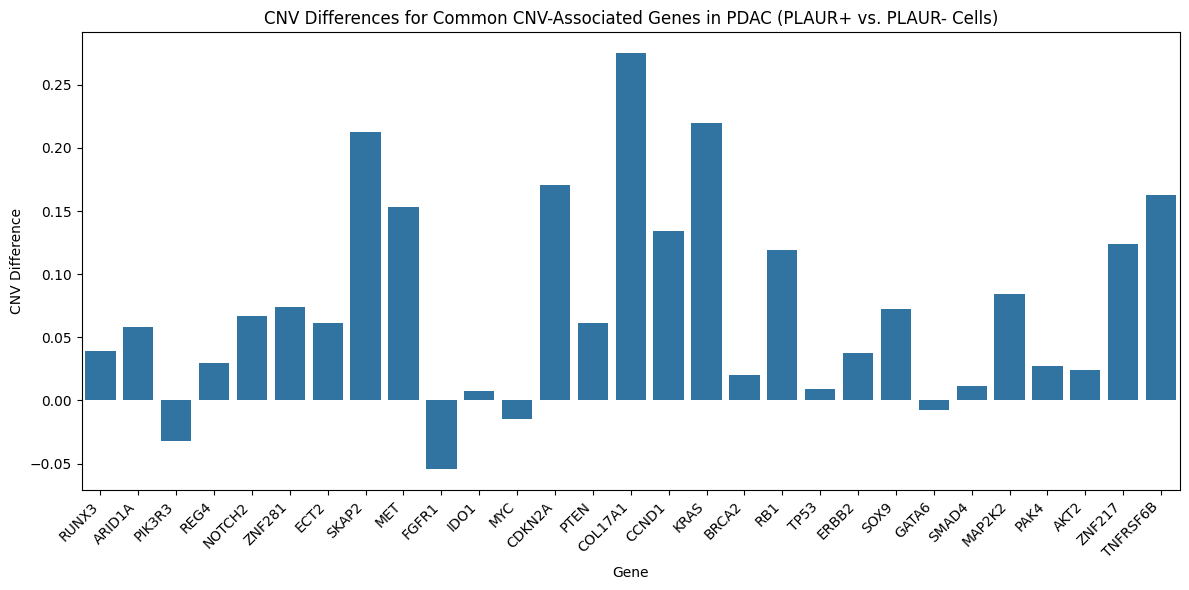

In [52]:
# Step 5: Plot the CNV differences for the genes of interest
plt.figure(figsize=(12, 6))  # Set figure size for better readability
sns.barplot(x='Gene', y='CNV_Difference', data=specific_genes_df)
plt.title('CNV Differences for Common CNV-Associated Genes in PDAC (PLAUR+ vs. PLAUR- Cells)')
plt.xlabel('Gene')
plt.ylabel('CNV Difference')

# Rotate x-axis labels to improve readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to ensure all elements fit within the plot
plt.tight_layout()
plt.show()

In [53]:
# Save the AnnData object to an .h5ad file
adata.write_h5ad(f'{base_data_path}/cnv_complete_analyses_PLAUR_subset_cells.h5ad')


... storing 'PLAUR_Status_Binary' as categorical


In [54]:
# Load the saved AnnData object from the .h5ad file
adata = sc.read_h5ad(f'{base_data_path}/cnv_complete_analyses_PLAUR_subset_cells.h5ad')
adata


AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'score_sig', 'cell_type', 'cnv_leiden', 'cnv_score', 'PLAUR_Status_Binary'
    var: 'n_cells', 'chromosome', 'start', 'end'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [57]:
# Load a pre-trained SCVI model and link it to the AnnData object
model = scvi.model.SCVI.load(f'{base_data_path}/model.model', adata)


INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model.model/model.pt already downloaded          


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = tor

## GSEA Analysis of Top CNV Genes in PLAUR+ vs PLAUR- Cells

In [59]:
# Step: Perform Pathway Enrichment Analysis using gseapy.enrichr

# Extract the list of significant genes from your CNV analysis
significant_gene_list = significant_genes['Gene'].tolist()

# Background gene list (all genes in your data)
background_genes = gene_names.tolist()


In [60]:
# Perform Enrichr pathway analysis using GO Biological Process 2021
enr_go = gp.enrichr(
    gene_list=significant_gene_list,                   # List of significant genes from CNV analysis
    gene_sets=['GO_Biological_Process_2021'],          # GO Biological Process 2021 gene set
    organism='human',                                  # Set organism to 'human'
    outdir=None,                                       # Don't write output files to disk
    background=background_genes                        # Background gene list from adata
)

In [61]:
# View the top enrichment results
print("\nTop Enriched Pathways:")
print(enr_go.results.head())  # Display the top results


Top Enriched Pathways:
                     Gene_set  \
0  GO_Biological_Process_2021   
1  GO_Biological_Process_2021   
2  GO_Biological_Process_2021   
3  GO_Biological_Process_2021   
4  GO_Biological_Process_2021   

                                                Term       P-value  \
0              neutrophil degranulation (GO:0043312)  3.906351e-25   
1  neutrophil activation involved in immune respo...  4.668529e-25   
2          neutrophil mediated immunity (GO:0002446)  5.330780e-25   
3  antigen processing and presentation of exogeno...  4.294694e-12   
4  antigen processing and presentation of peptide...  4.294694e-12   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0      1.359349e-22            0                     0   49.232606   
1      1.359349e-22            0                     0   48.790464   
2      1.359349e-22            0                     0   48.463947   
3      6.570881e-10            0                     0   64.556564   
4     

<Axes: title={'center': 'Top GO Biological Processes for Significant CNV Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

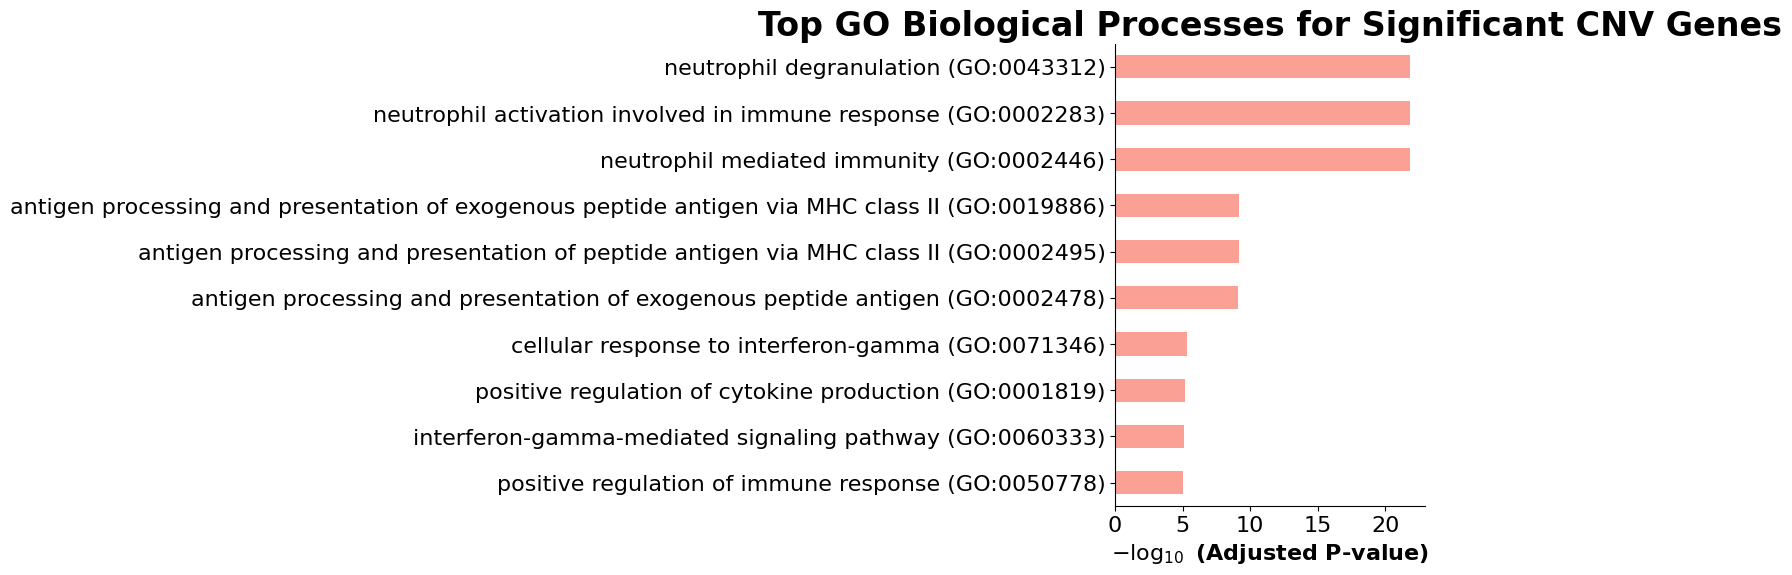

In [64]:
# Optional: Plot the top enriched pathways
gp.barplot(enr_go.res2d, title='Top GO Biological Processes for Significant CNV Genes')

In [65]:
# List all available gene sets from gseapy
available_gene_sets = gp.get_library_name()
print("Available Gene Sets for Enrichment Analysis:")
print(available_gene_sets)

Available Gene Sets for Enrichment Analysis:
['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sang

In [66]:
# Step: Perform Pathway Enrichment Analysis using gseapy.enrichr

# Extract the list of significant genes from your CNV analysis
significant_gene_list = significant_genes['Gene'].tolist()

# Background gene list (all genes in your data)
background_genes = gene_names.tolist()

In [67]:
# Perform Enrichr pathway analysis using MSigDB Hallmark 2020 gene set
enr_go = gp.enrichr(
    gene_list=significant_gene_list,                   # List of significant genes from CNV analysis
    gene_sets=['MSigDB_Hallmark_2020'],                # MSigDB Hallmark 2020 gene set
    organism='human',                                  # Set organism to 'human'
    outdir=None,                                       # Don't write output files to disk
    background=background_genes                        # Background gene list from adata
)

In [68]:
# View the top enrichment results
print("\nTop Enriched Pathways:")
print(enr_go.results.head())  # Display the top results


Top Enriched Pathways:
               Gene_set                           Term       P-value  \
0  MSigDB_Hallmark_2020                     Complement  4.839953e-08   
1  MSigDB_Hallmark_2020              KRAS Signaling Up  1.038090e-06   
2  MSigDB_Hallmark_2020      Interferon Gamma Response  1.101335e-06   
3  MSigDB_Hallmark_2020                    p53 Pathway  1.930683e-05   
4  MSigDB_Hallmark_2020  TNF-alpha Signaling via NF-kB  2.348811e-05   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.000001            0                     0   24.711572   
1          0.000010            0                     0   20.980263   
2          0.000010            0                     0   20.760156   
3          0.000132            0                     0   17.332725   
4          0.000132            0                     0   16.616635   

   Combined Score                                     Genes  
0      416.236172  LGALS3;CEBPB;FCER1G;PLAUR;CTSD;CTSS;CTSB 

<Axes: title={'center': 'Top MSigDB Hallmark 2020 Pathways for Significant CNV Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

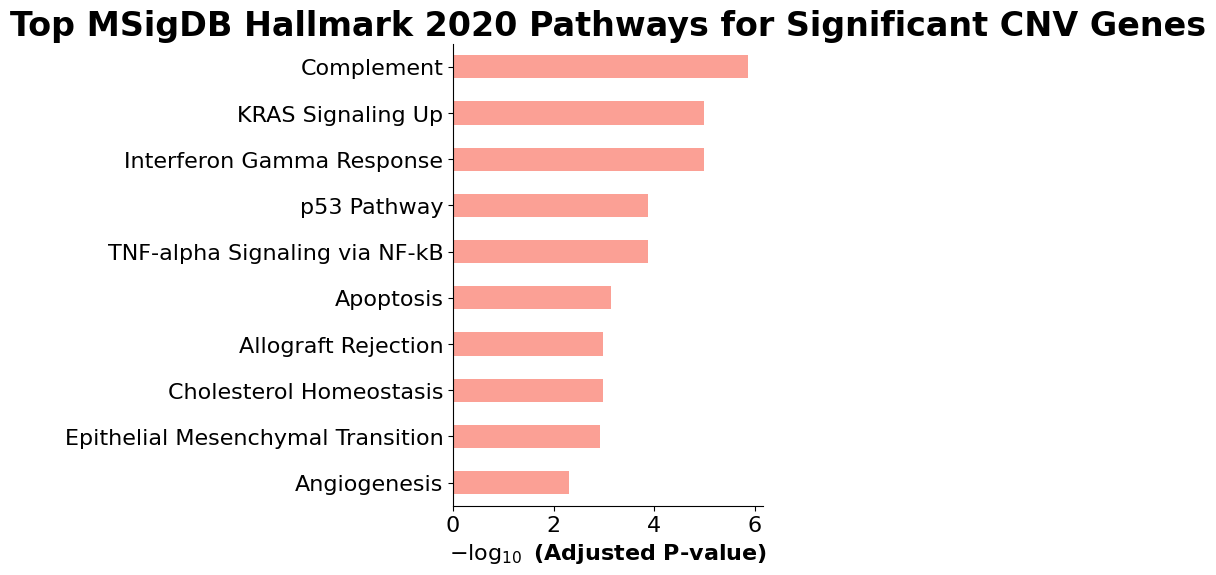

In [69]:
# Optional: Plot the top enriched pathways
gp.barplot(enr_go.res2d, title='Top MSigDB Hallmark 2020 Pathways for Significant CNV Genes')

In [70]:
# Extract the list of significant genes from your CNV analysis
significant_gene_list = significant_genes['Gene'].tolist()

# Background gene list (all genes in your data)
background_genes = gene_names.tolist()


In [71]:
# Perform Enrichr pathway analysis using MSigDB Oncogenic Signatures
enr_go = gp.enrichr(
    gene_list=significant_gene_list,                   # List of significant genes from CNV analysis
    gene_sets=['MSigDB_Oncogenic_Signatures'],         # MSigDB Oncogenic Signatures gene set
    organism='human',                                  # Set organism to 'human'
    outdir=None,                                       # Don't write output files to disk
    background=background_genes                        # Background gene list from adata
)

In [72]:
# View the top enrichment results
print("\nTop Enriched Pathways:")
print(enr_go.results.head())  # Display the top results


Top Enriched Pathways:
                      Gene_set                    Term   P-value  \
0  MSigDB_Oncogenic_Signatures  ESC V6.5 UP LATE.V1 DN  0.000202   
1  MSigDB_Oncogenic_Signatures          HOXA9 DN.V1 UP  0.000236   
2  MSigDB_Oncogenic_Signatures          RPS14 DN.V1 UP  0.000263   
3  MSigDB_Oncogenic_Signatures           BMI1 DN.V1 DN  0.001452   
4  MSigDB_Oncogenic_Signatures          MEL18 DN.V1 UP  0.001584   

   Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0          0.006831            0                     0   15.353535   
1          0.006831            0                     0   14.724806   
2          0.006831            0                     0   14.306161   
3          0.024704            0                     0   14.633584   
4          0.024704            0                     0   14.184626   

   Combined Score                        Genes  
0      130.599640       LGALS3;MGP;SPP1;S100A4  
1      122.968807  FCER1G;TYROBP;HLA-DRA;IFI30  

<Axes: title={'center': 'Top MSigDB Oncogenic Signatures for Significant CNV Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

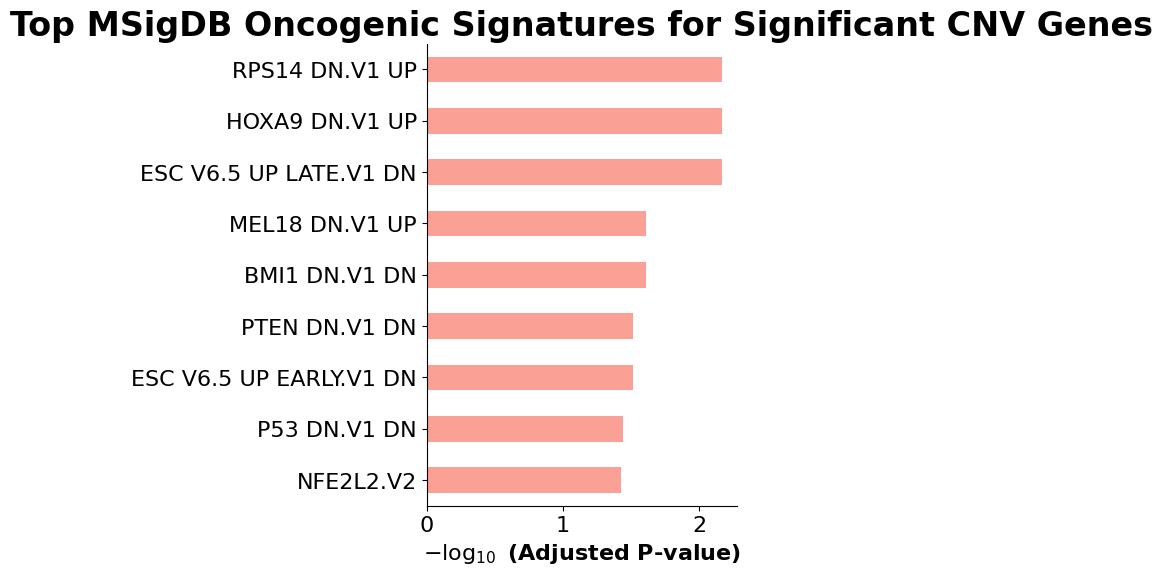

In [73]:
# Optional: Plot the top enriched pathways
gp.barplot(enr_go.res2d, title='Top MSigDB Oncogenic Signatures for Significant CNV Genes')

# Key Steps for Interpreting Enrichment Analysis Results

To interpret the enrichment analysis results, focus on key metrics such as enrichment scores, statistical significance, and specific gene signatures. Here’s a structured approach:

## 1. Check Enrichment Scores (NES)
- **Identify Oncogenic Pathways**: Look for pathways with the highest positive or negative Normalized Enrichment Scores (NES). 
- **Positive NES**: Indicates pathways that are upregulated or activated.
- **Negative NES**: Indicates pathways that are downregulated or repressed.

## 2. Look at P-values and FDR
- **Significance Check**: Focus on pathways with low p-values and an FDR < 0.25 to ensure statistical significance.
- **Interpret Meaning**: Statistically significant pathways suggest robust changes that may be biologically relevant in your data.

## 3. Review Leading-edge Genes
- **Leading-edge Genes**: Identify the subset of genes driving the enrichment, as these may provide insight into key regulatory pathways and potential therapeutic targets.

## 4. Investigate Oncogene Signatures
- **Pathway Activation or Suppression**: Evaluate specific oncogene signatures (e.g., KRAS, MYC, TP53) to understand whether they are active or repressed in your dataset.
  
---

## Practical Example

Suppose the top enriched pathways in your results include:

1. **KRAS.LUNG_UP.V1_UP**: NES = 2.1, FDR = 0.01
2. **MYC.V1_UP**: NES = 1.9, FDR = 0.02
3. **TP53_DN.V1_DN**: NES = -1.8, FDR = 0.03

### Interpretation:
- **KRAS.LUNG_UP.V1_UP and MYC.V1_UP**: The positive enrichment scores indicate that the KRAS and MYC pathways are activated in your dataset, potentially driving oncogenic processes.
- **TP53_DN.V1_DN**: The negative NES suggests that the TP53 tumor suppressor pathway is downregulated, implying inactivation of TP53, which is common in many cancers.

**Summary**: This combination suggests that KRAS and MYC activation may promote tumor growth, while TP53 repression could facilitate unchecked proliferation, a common cancer hallmark.

---

## Specific Example Interpretation:

### ESC V6.5 UP LATE.V1 DN
- **Context**: This gene set represents genes typically upregulated in late differentiation stages of embryonic stem cells (ESCs).
- **Downregulated in Your Data**: In your sample, these genes are downregulated, suggesting that normal differentiation may be blocked, potentially indicating a stem cell-like or undifferentiated state. This may be relevant for cancer or developmental studies.

### P53 DN.v1 UP
- **Gene Set Context**: This set includes genes normally repressed by the p53 tumor suppressor pathway when active.
- **Upregulated in Your Data**: In your dataset, these genes are upregulated, suggesting that the p53 pathway may be inactive, compromised, or mutated.
- **Biological Interpretation**:
  - **p53 Inactivation**: p53 usually suppresses these genes, so their upregulation could indicate p53 loss of function, a frequent occurrence in cancers.
  - **Oncogenesis**: Loss of p53 tumor suppression may lead to evasion of apoptosis, unchecked cell division, and increased cancer risk.

**Summary**: The upregulation of genes normally suppressed by p53 suggests p53 inactivation, potentially increasing oncogenic potential by removing critical tumor suppression.

---

## BMI-1 Gene Example

**BMI-1 DN v1.DN** refers to genes typically upregulated when BMI-1 is downregulated. 


In [74]:
# Step: Perform Pathway Enrichment Analysis using gseapy.enrichr

# Extract the list of significant genes from your CNV analysis
significant_gene_list = significant_genes['Gene'].tolist()

# Background gene list (all genes in your data)
background_genes = gene_names.tolist()

In [75]:
# Perform Enrichr pathway analysis using Reactome 2022
enr_go = gp.enrichr(
    gene_list=significant_gene_list,                   # List of significant genes from CNV analysis
    gene_sets=['Reactome_2022'],                       # Reactome 2022 gene set
    organism='human',                                  # Set organism to 'human'
    outdir=None,                                       # Don't write output files to disk
    background=background_genes                        # Background gene list from adata
)

In [76]:
# View the top enrichment results
print("\nTop Enriched Pathways:")
print(enr_go.results.head())  # Display the top results


Top Enriched Pathways:
        Gene_set                                             Term  \
0  Reactome_2022           Neutrophil Degranulation R-HSA-6798695   
1  Reactome_2022                       Immune System R-HSA-168256   
2  Reactome_2022                Innate Immune System R-HSA-168249   
3  Reactome_2022  MHC Class II Antigen Presentation R-HSA-2132295   
4  Reactome_2022             Adaptive Immune System R-HSA-1280218   

        P-value  Adjusted P-value  Old P-value  Old adjusted P-value  \
0  7.151640e-19      1.051291e-16            0                     0   
1  2.144597e-15      1.576279e-13            0                     0   
2  6.559935e-15      3.214368e-13            0                     0   
3  7.086710e-12      2.604366e-10            0                     0   
4  2.420542e-08      7.116394e-07            0                     0   

   Odds Ratio  Combined Score  \
0   35.072492     1465.390977   
1   13.885984      469.010574   
2   17.938214      585.822512

<Axes: title={'center': 'Top Reactome 2022 Pathways for Significant CNV Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

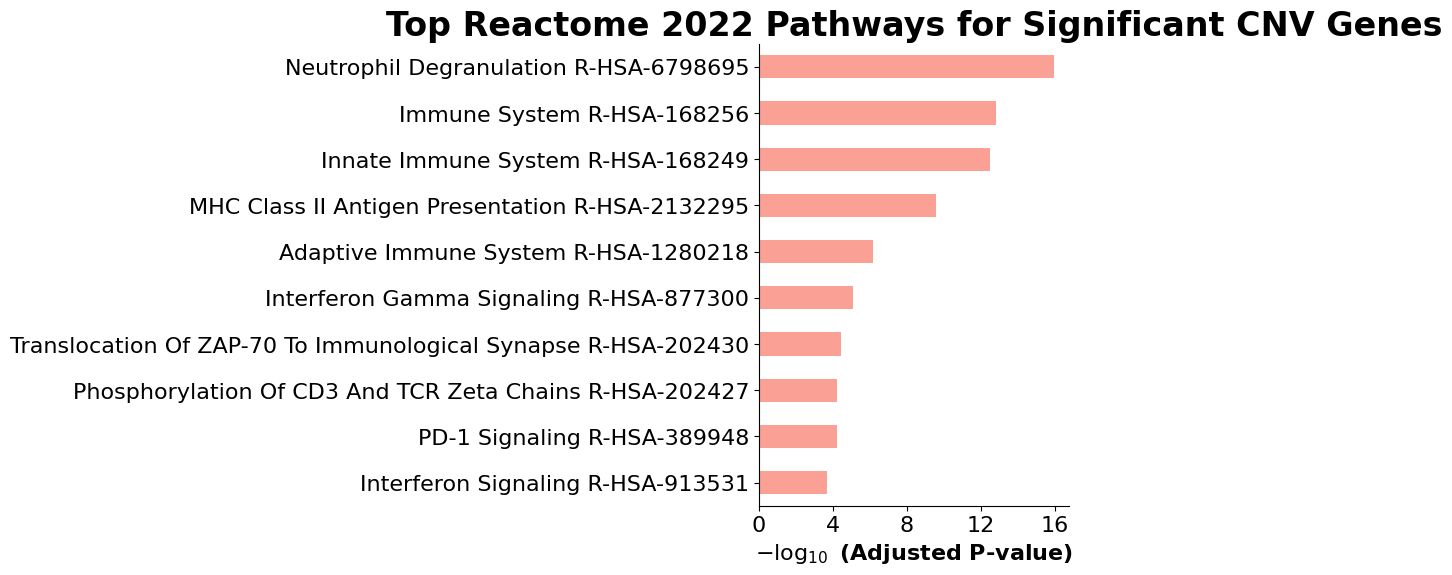

In [77]:
# Optional: Plot the top enriched pathways
gp.barplot(enr_go.res2d, title='Top Reactome 2022 Pathways for Significant CNV Genes')

In [78]:
# Step: Perform Pathway Enrichment Analysis using gseapy.enrichr

# Extract the list of significant genes from your CNV analysis
significant_gene_list = significant_genes['Gene'].tolist()

# Background gene list (all genes in your data)
background_genes = gene_names.tolist()

In [79]:
# Perform Enrichr pathway analysis using Chromosome Location hg19
enr_go = gp.enrichr(
    gene_list=significant_gene_list,                   # List of significant genes from CNV analysis
    gene_sets=['Chromosome_Location_hg19'],            # Chromosome Location hg19 gene set
    organism='human',                                  # Set organism to 'human'
    outdir=None,                                       # Don't write output files to disk
    background=background_genes                        # Background gene list from adata
)

In [80]:
# View the top enrichment results
print("\nTop Enriched Pathways:")
print(enr_go.results.head())  # Display the top results


Top Enriched Pathways:
                   Gene_set            Term   P-value  Adjusted P-value  \
0  Chromosome_Location_hg19  chr6 ssto hap7  0.000069          0.001354   
1  Chromosome_Location_hg19   chr6 qbl hap6  0.000128          0.001354   
2  Chromosome_Location_hg19   chr6 cox hap2  0.000156          0.001354   
3  Chromosome_Location_hg19  chr6 mann hap4  0.001210          0.007863   
4  Chromosome_Location_hg19   chr6 mcf hap5  0.001795          0.009333   

   Old P-value  Old adjusted P-value  Odds Ratio  Combined Score  \
0            0                     0   20.461598      195.980108   
1            0                     0   17.363992      155.651469   
2            0                     0   16.457019      144.231608   
3            0                     0   15.622044      104.939241   
4            0                     0   13.560346       85.739832   

                             Genes  
0  HLA-B;HLA-DRA;HLA-DRB1;HLA-DPA1  
1  HLA-B;HLA-DRA;HLA-DRB1;HLA-DPA1  
2  HL

<Axes: title={'center': 'Top Chromosome Location hg19 for Significant CNV Genes'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

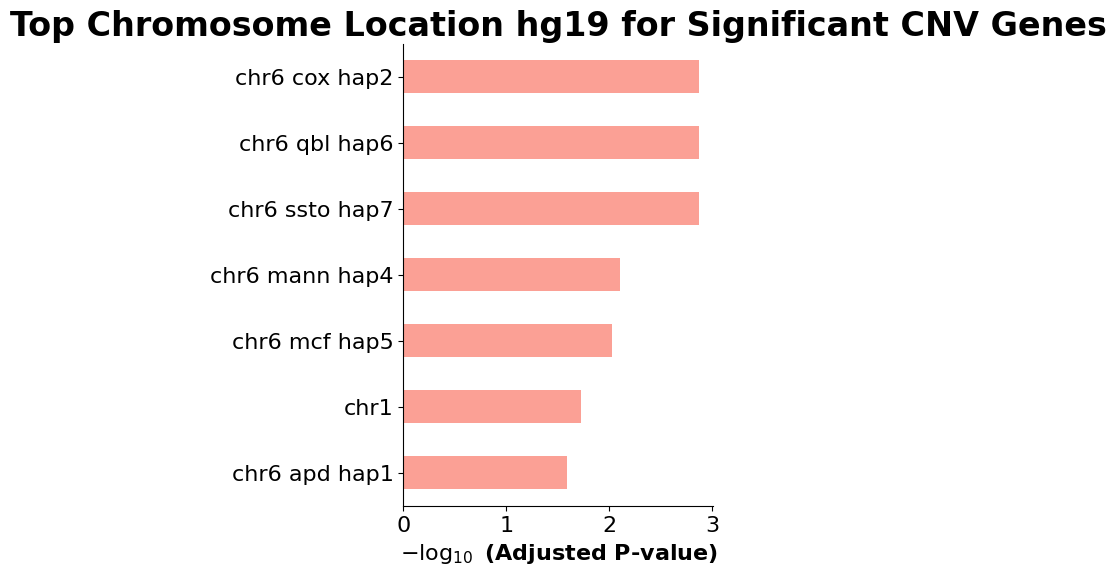

In [81]:
# Optional: Plot the top enriched pathways
gp.barplot(enr_go.res2d, title='Top Chromosome Location hg19 for Significant CNV Genes')

# Differential CNV Burden Analysis Between PLAUR+ and PLAUR- Cells

### Objective:
The goal of this analysis is to quantify and compare the total CNV burden (the number of genes affected by CNVs) between two cell groups: PLAUR+ and PLAUR-.

---

## Steps for Differential CNV Burden Analysis

### 1. Compute CNV Burden
- **Definition**: CNV burden represents the total number of CNVs (both amplifications and deletions) affecting genes within each cell.
- **Approach**: For each cell, count the total number of genes affected by CNVs, irrespective of whether the CNV is a gain or loss.

### 2. Group Cells by PLAUR Status
- **Group Assignment**: Divide cells into two groups based on `PLAUR_Status_Binary`:
  - **PLAUR+**: Cells expressing PLAUR (labeled as "PLAUR+").
  - **PLAUR-**: Cells without PLAUR expression (labeled as "PLAUR-").

### 3. Statistical Comparison
- **Objective**: Assess if there is a significant difference in CNV burden between PLAUR+ and PLAUR- cells.
- **Statistical Tests**:
  - **t-test**: Use if the data distribution meets normality assumptions.
  - **Mann-Whitney U Test**: Use if the data distribution does not meet normality assumptions, as this test is non-parametric and robust to distribution differences.

### 4. Visualization
- **Boxplot or Violin Plot**: Use these visualizations to compare the distribution of CNV burden between PLAUR+ and PLAUR- cells.
  - **Boxplot**: Shows median and quartiles, highlighting central tendency and spread of CNV burden.
  - **Violin Plot**: Combines boxplot elements with a density plot, providing insight into the distribution shape of CNV burden across cells.

---

## Interpretation
By analyzing the CNV burden distribution and comparing between PLAUR+ and PLAUR- cells, this analysis can reveal whether CNV burden is more prominent in one group, potentially indicating a differential role of CNVs in cells based on PLAUR expression status.


In [82]:
# Step 1: Run inferCNV on combined data (PLAUR+ and PLAUR- together)
print("Running inferCNV on combined data...")
cnv.tl.infercnv(
    combined_data,
    reference_key='cell_type',         # Column containing cell type labels
    reference_cat=normal_cell_types,   # Categories for reference (normal) cells
    window_size=200                    # Window size for CNV analysis
)


Running inferCNV on combined data...


  0%|          | 0/12 [00:00<?, ?it/s]

In [83]:
# Step 2: Extract the CNV matrix from inferCNV results
# The results are stored in the `obsm` attribute of the AnnData object
cnv_matrix = combined_data.obsm['X_cnv']  # Matrix of CNV results (genes x cells)

In [84]:
# Step 3: Compute the CNV burden for each cell
# Binarize the CNV data: Treat any non-zero value as a CNV (gain or loss)
cnv_binarized = (cnv_matrix != 0).astype(int)

In [85]:
# Sum CNVs per cell to calculate the CNV burden
cnv_burden_per_cell = cnv_binarized.sum(axis=1)

In [86]:
# Step 4: Add the CNV burden to cell metadata in the AnnData object
combined_data.obs['CNV_Burden'] = cnv_burden_per_cell

In [87]:
# Step 5: Separate cells into PLAUR+ and PLAUR- groups based on CNV burden
plaured_positive_cells = combined_data.obs[combined_data.obs['PLAUR_Status_Binary'] == 'PLAUR+']
plaured_negative_cells = combined_data.obs[combined_data.obs['PLAUR_Status_Binary'] == 'PLAUR-']

In [88]:
# Extract CNV burden values for each group
cnv_burden_plaured_positive = plaured_positive_cells['CNV_Burden']
cnv_burden_plaured_negative = plaured_negative_cells['CNV_Burden']

In [89]:
# Step 6: Statistical comparison using Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(cnv_burden_plaured_positive, cnv_burden_plaured_negative)
print(f"Mann-Whitney U test result: U-statistic = {u_stat}, p-value = {p_val}")


Mann-Whitney U test result: U-statistic = 377290688.5, p-value = 4.847422631519061e-187


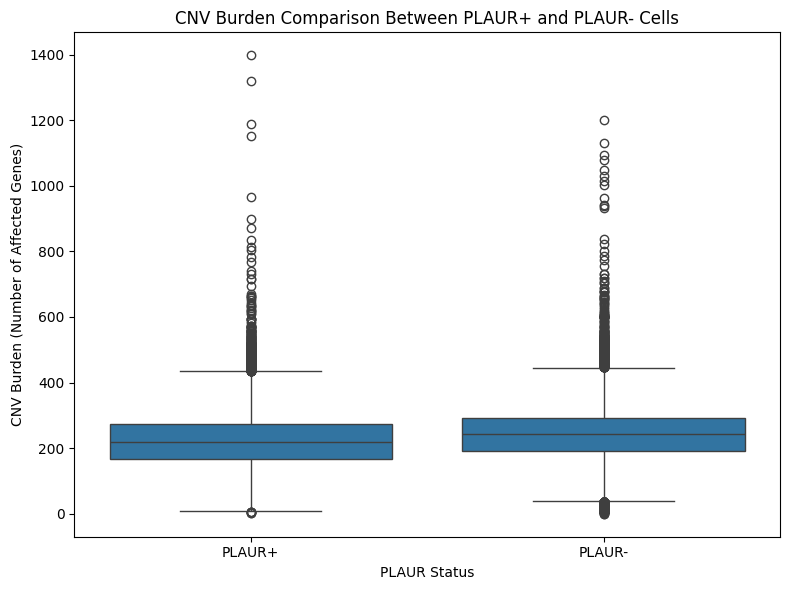

In [90]:
# Step 7: Visualize the CNV burden distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x=combined_data.obs['PLAUR_Status_Binary'], y=combined_data.obs['CNV_Burden'])
plt.title('CNV Burden Comparison Between PLAUR+ and PLAUR- Cells')
plt.xlabel('PLAUR Status')
plt.ylabel('CNV Burden (Number of Affected Genes)')
plt.tight_layout()
plt.show()

## Assessing Normality and Comparing CNV Burden Between PLAUR+ and PLAUR- Cells Using Mann-Whitney U Test

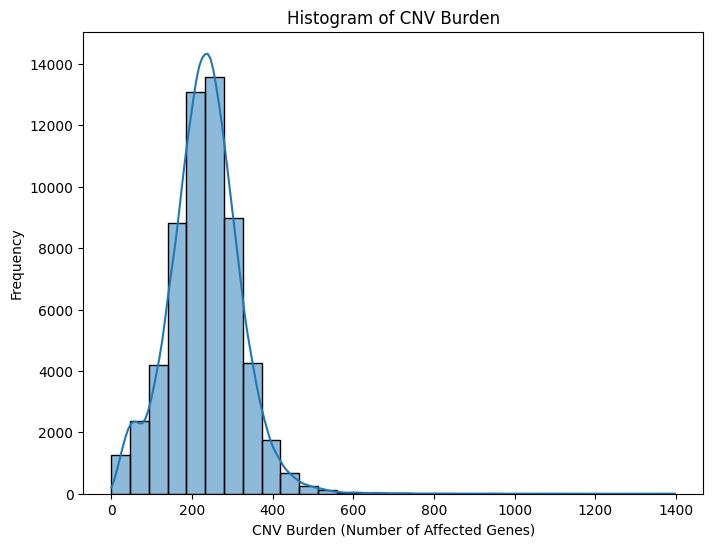

In [91]:
# Assuming `combined_data.obs['CNV_Burden']` holds your CNV burden values

# Step 1: Visualize the distribution using a histogram
plt.figure(figsize=(8, 6))
sns.histplot(combined_data.obs['CNV_Burden'], bins=30, kde=True)
plt.title('Histogram of CNV Burden')
plt.xlabel('CNV Burden (Number of Affected Genes)')
plt.ylabel('Frequency')
plt.show()

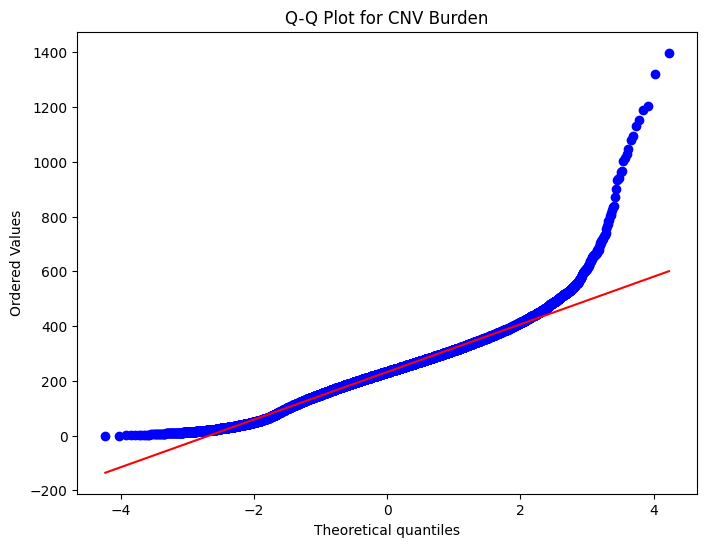

In [92]:
# Step 2: Q-Q Plot to compare CNV Burden with a normal distribution
plt.figure(figsize=(8, 6))
stats.probplot(combined_data.obs['CNV_Burden'], dist="norm", plot=plt)
plt.title('Q-Q Plot for CNV Burden')
plt.show()

In [97]:
sample_data = combined_data.obs['CNV_Burden'].sample(n=5000, random_state=42)
shapiro_stat, shapiro_p = stats.shapiro(sample_data)
print(f"Shapiro-Wilk Test on 5000-sample: W-statistic = {shapiro_stat}, p-value = {shapiro_p}")

Shapiro-Wilk Test on 5000-sample: W-statistic = 0.9738250853807344, p-value = 2.5031236143827887e-29


In [95]:
# Step 4: Kolmogorov-Smirnov Test
ks_stat, ks_p = stats.kstest(
    combined_data.obs['CNV_Burden'], 'norm', 
    args=(np.mean(combined_data.obs['CNV_Burden']), np.std(combined_data.obs['CNV_Burden']))
)
print(f"Kolmogorov-Smirnov Test: KS-statistic = {ks_stat}, p-value = {ks_p}")

Kolmogorov-Smirnov Test: KS-statistic = 0.028348819525259805, p-value = 5.821856933676729e-42


In [96]:
# Step 5: D’Agostino and Pearson’s Test
k2_stat, k2_p = stats.normaltest(combined_data.obs['CNV_Burden'])
print(f"D’Agostino and Pearson’s Test: K2-statistic = {k2_stat}, p-value = {k2_p}")

D’Agostino and Pearson’s Test: K2-statistic = 7625.829736443688, p-value = 0.0


# Interpretation of Normality Tests for CNV Burden Data

The results from the normality tests (Shapiro-Wilk, Kolmogorov-Smirnov, and D'Agostino and Pearson’s tests) indicate that the CNV burden data is not normally distributed. Here’s a detailed breakdown:

---

## Shapiro-Wilk Test
- **W-statistic**: 0.9851  
- **p-value**: 1.13e-60  
- **Interpretation**: The Shapiro-Wilk test evaluates whether the data is normally distributed. Since the p-value is significantly below 0.05, we reject the null hypothesis of normality. This extremely small p-value (1.13e-60) strongly suggests that the data deviates from a normal distribution.
- **Warning**: A warning was issued because the sample size exceeds 5,000, which can affect the accuracy of this test. However, the very small p-value still indicates non-normality.

## Kolmogorov-Smirnov Test
- **KS-statistic**: 0.0249  
- **p-value**: 1.57e-38  
- **Interpretation**: The Kolmogorov-Smirnov test compares the observed distribution with a normal distribution. The p-value of 1.57e-38 is far below 0.05, meaning we reject the null hypothesis and conclude that the data does not follow a normal distribution.  
- **KS-statistic**: The statistic (0.0249) quantifies the deviation between the data and a normal distribution. Although the statistic is relatively small, the extremely low p-value indicates that this deviation is statistically significant.

## D'Agostino and Pearson’s Test
- **K2-statistic**: 4722.22  
- **p-value**: 0.0  
- **Interpretation**: This test assesses normality by considering both skewness and kurtosis. A p-value of 0.0 leads us to reject the null hypothesis, confirming non-normality in the data. The high K2-statistic suggests a considerable departure from normality.

---

### Summary
All three tests (Shapiro-Wilk, Kolmogorov-Smirnov, and D'Agostino and Pearson) indicate that the CNV burden data is not normally distributed. Consequently, non-parametric tests, such as the Mann-Whitney U test, are more suitable for further analysis when comparing CNV burden b


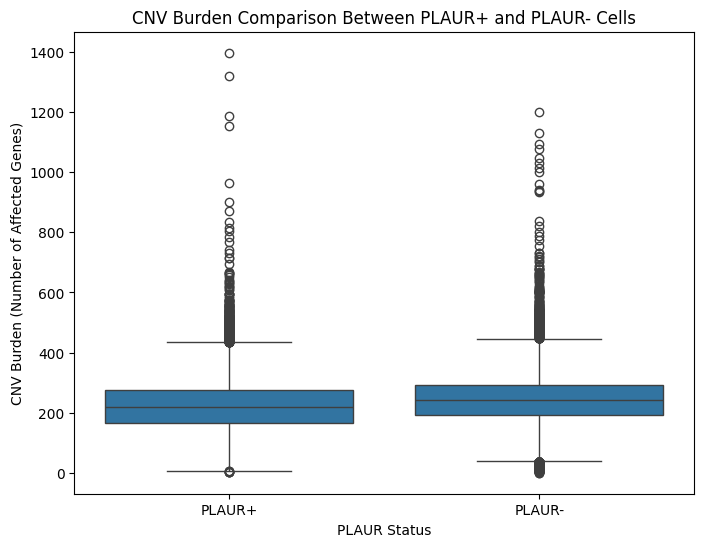

In [98]:
# Step 5: Visualize the CNV burden distribution

# Boxplot to compare CNV burden between PLAUR+ and PLAUR- cells
plt.figure(figsize=(8, 6))
sns.boxplot(x=combined_data.obs['PLAUR_Status_Binary'], y=combined_data.obs['CNV_Burden'])
plt.title('CNV Burden Comparison Between PLAUR+ and PLAUR- Cells')
plt.xlabel('PLAUR Status')
plt.ylabel('CNV Burden (Number of Affected Genes)')
plt.show()

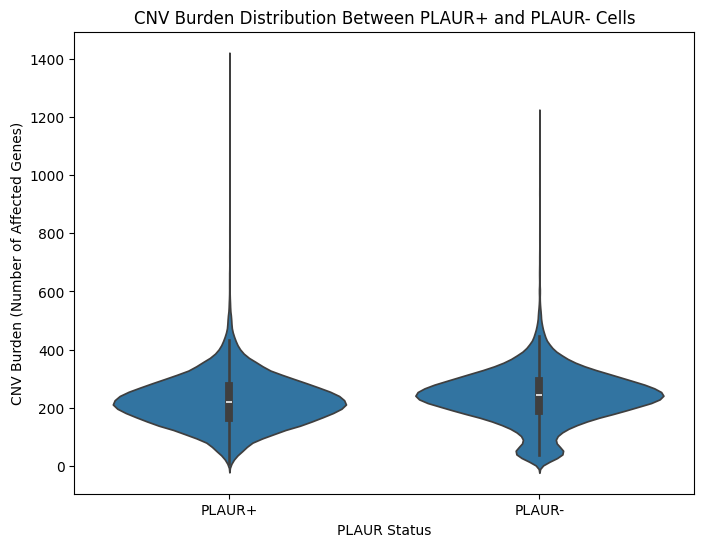

In [99]:
# Optional: Violin plot to show CNV burden distribution shape
plt.figure(figsize=(8, 6))
sns.violinplot(x=combined_data.obs['PLAUR_Status_Binary'], y=combined_data.obs['CNV_Burden'])
plt.title('CNV Burden Distribution Between PLAUR+ and PLAUR- Cells')
plt.xlabel('PLAUR Status')
plt.ylabel('CNV Burden (Number of Affected Genes)')
plt.show()

# Explanation of Differential CNV Burden Analysis

### 1. CNV Binarization
- **Process**: The `cnv_data` matrix holds CNV values for each gene across cells. To quantify the CNV burden, we first binarize this matrix.
- **Binarization**: Any non-zero CNV value, whether an amplification or deletion, is converted to `1`, indicating that the gene is affected by a CNV. This binary matrix reflects whether each gene is altered by a CNV without distinguishing the type (gain or loss).

### 2. CNV Burden Calculation
- **Definition**: CNV burden represents the total number of genes affected by CNVs in each cell.
- **Calculation**: For each cell, we sum the binarized CNV values across all genes. The resulting value provides the total number of genes with CNVs for each cell, quantifying the CNV burden.

### 3. Group Cells by PLAUR Status
- **Grouping**: Cells are categorized into two groups (PLAUR+ and PLAUR-) based on the `PLAUR_Status_Binary` column in the metadata. This grouping allows us to compare CNV burden based on PLAUR expression.

### 4. Statistical Comparison
- **Objective**: To determine if there is a significant difference in CNV burden between PLAUR+ and PLAUR- cells.
- **Tests**: 
  - **t-test**: If the data is normally distributed, a t-test can be used to compare the mean CNV burden between groups.
  - **Mann-Whitney U Test**: If normality assumptions are violated, we use this non-parametric test to compare CNV burden between the two groups without assuming a specific distribution.

### 5. Visualization
- **Boxplot**: Provides a visual summary of CNV burden for each group, showing the median, quartiles, and potential outliers.
- **Violin Plot (Optional)**: Combines a boxplot with a density plot, illustrating the distribution shape of CNV burden in each group and highlighting regions where data points are concentrated.

---

These steps allow us to quantify, compare, and visually explore CNV burden between PLAUR+ and PLAUR- cells, helping reveal whether PLAUR expression is associated with differential CNV burden.


## UMAP Visualization of PLAUR+ and PLAUR- Cell Distribution

In [119]:
# Load the AnnData object containing epithelial cell data with PLAUR status
epithelial_cells = sc.read_h5ad(f'{base_data_path}/epith_subset_plaur_status.h5ad')


In [120]:
# Assuming epithelial_cells is your AnnData object with PLAUR_Status already defined in `obs`

# Step 1: Ensure UMAP coordinates are computed
# If UMAP is not already computed, perform PCA and UMAP to embed the cells in 2D space
if 'X_umap' not in epithelial_cells.obsm:
    # Normalize and scale the data if not already done
    sc.pp.normalize_total(epithelial_cells, target_sum=1e4)
    sc.pp.log1p(epithelial_cells)
    sc.pp.highly_variable_genes(epithelial_cells, min_mean=0.0125, max_mean=3, min_disp=0.5)
    epithelial_cells = epithelial_cells[:, epithelial_cells.var.highly_variable]
    sc.pp.scale(epithelial_cells, max_value=10)

    # PCA for dimensionality reduction
    sc.tl.pca(epithelial_cells, svd_solver='arpack')

    # Compute UMAP based on PCA representation
    sc.pp.neighbors(epithelial_cells, n_neighbors=10, n_pcs=40)
    sc.tl.umap(epithelial_cells)

<Figure size 1000x800 with 0 Axes>

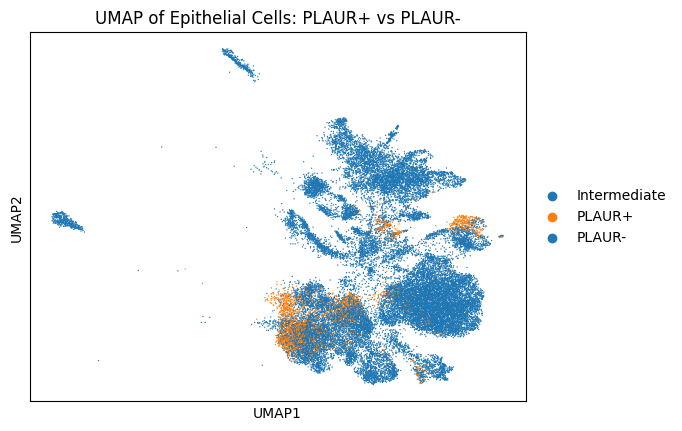

In [121]:
# Step 2: Plot UMAP of PLAUR+ and PLAUR- cells
plt.figure(figsize=(10, 8))

# Color cells by PLAUR_Status to differentiate PLAUR+ and PLAUR- cells
sc.pl.umap(
    epithelial_cells, 
    color='PLAUR_Status', 
    title='UMAP of Epithelial Cells: PLAUR+ vs PLAUR-', 
    palette=['#1f77b4', '#ff7f0e'], 
    show=True
)

<Figure size 1000x800 with 0 Axes>

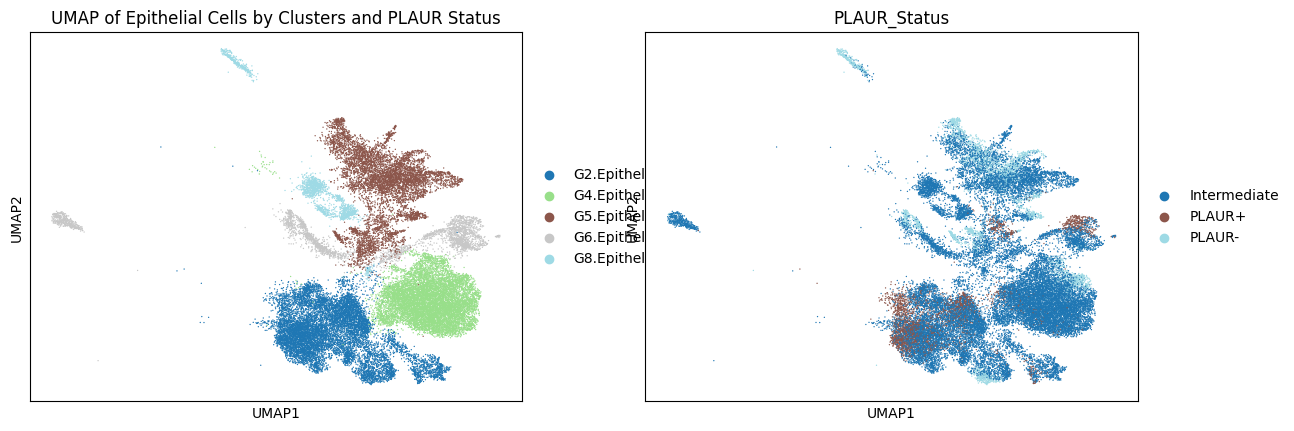

In [122]:
# Optional: Plot clusters along with PLAUR+ and PLAUR- cell status
plt.figure(figsize=(10, 8))
sc.pl.umap(
    epithelial_cells, 
    color=['cell_type', 'PLAUR_Status'], 
    title='UMAP of Epithelial Cells by Clusters and PLAUR Status', 
    palette='tab20', 
    show=True
)

In [123]:
# Step 3: Extract PLAUR+ and PLAUR- cells based on existing labeling in 'PLAUR_Status'
plaured_positive_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'PLAUR+']
plaured_negative_cells = epithelial_cells[epithelial_cells.obs['PLAUR_Status'] == 'PLAUR-']


In [114]:
plaured_positive_cells

View of AnnData object with n_obs × n_vars = 3257 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_type', 'cnv_leiden', 'cnv_score', 'PLAUR_Status'
    var: 'n_cells', 'chromosome', 'start', 'end', 'gene_symbol'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cnv', 'cnv_leiden', 'cnv_leiden_colors', 'cnv_neighbors', 'dendrogram_cnv_leiden', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'pca', 'predicted_labels_colors', 'rank_genes_groups', 'umap', 'PLAUR_Status_colors'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'cnv_neighbors_connectivities', '

In [124]:
# Step 1: Prepare CNV Data
# Extract CNV data for PLAUR+ and PLAUR- cells
cnv_matrix_positive = plaured_positive_cells.obsm['X_cnv']
cnv_matrix_negative = plaured_negative_cells.obsm['X_cnv']

In [127]:
# Convert sparse matrices to dense arrays if necessary
if scipy.sparse.issparse(cnv_matrix_positive):
    cnv_matrix_positive = cnv_matrix_positive.toarray()
if scipy.sparse.issparse(cnv_matrix_negative):
    cnv_matrix_negative = cnv_matrix_negative.toarray()


In [128]:
# Concatenate PLAUR+ and PLAUR- CNV matrices
cnv_combined_matrix = np.vstack((cnv_matrix_positive, cnv_matrix_negative))


In [129]:
# Step 2: Apply PCA for Dimensionality Reduction
# Reduce dimensionality to 20 principal components for efficient clustering
pca = PCA(n_components=20)
cnv_combined_pca = pca.fit_transform(cnv_combined_matrix)

In [130]:
# Step 3: Create a DataFrame for clustering
# Label cells as PLAUR+ or PLAUR- for plotting
plaur_labels = ['PLAUR+'] * cnv_matrix_positive.shape[0] + ['PLAUR-'] * cnv_matrix_negative.shape[0]
cnv_df_pca = pd.DataFrame(cnv_combined_pca, index=plaur_labels)


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x1200 with 0 Axes>

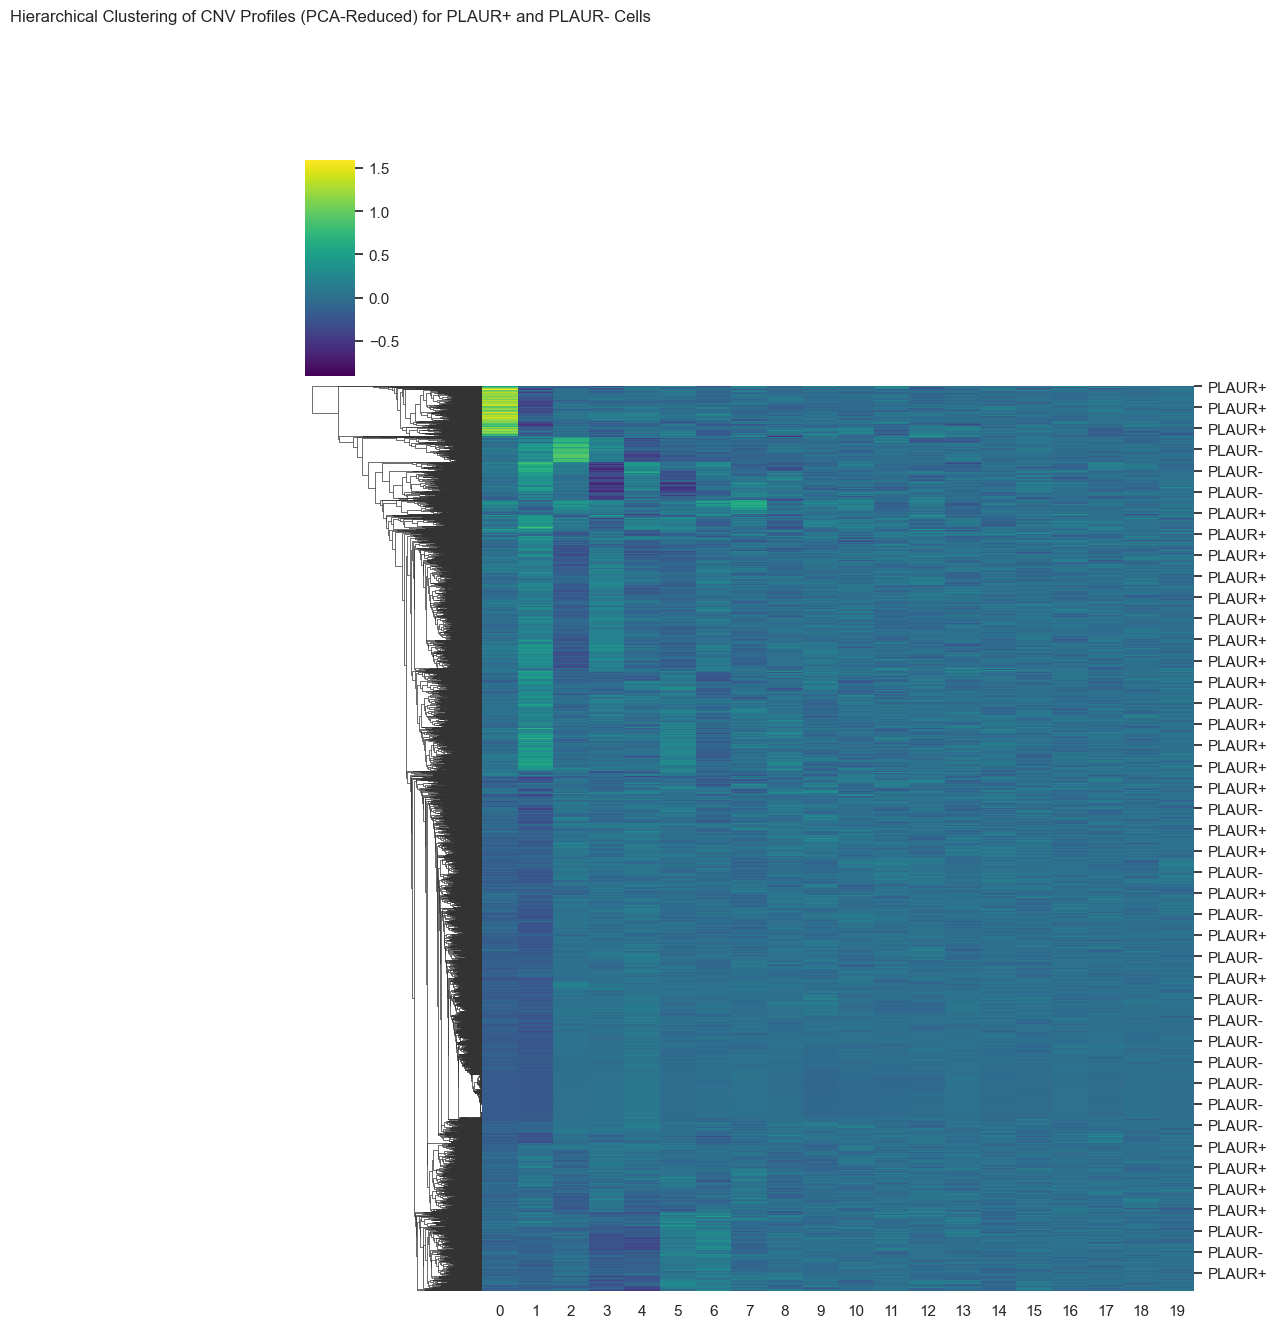

In [133]:
# Step 4: Perform Hierarchical Clustering and Visualization
# Using seaborn's clustermap for hierarchical clustering visualization
sns.set(style='white')
plt.figure(figsize=(10, 12))

g = sns.clustermap(
    cnv_df_pca,
    method='average',       # Linkage method for clustering
    metric='euclidean',     # Distance metric for clustering
    cmap='viridis',         # Color map
    col_cluster=False,      # Do not cluster columns (focus on rows)
    figsize=(10, 12)        # Figure size for clustermap
)

# Customize plot with labels and title
plt.title('Hierarchical Clustering of CNV Profiles (PCA-Reduced) for PLAUR+ and PLAUR- Cells', pad=100)
plt.show()

In [135]:
# Extract linkage matrix from the clustermap
linkage_matrix = g.dendrogram_row.linkage

# Define the number of clusters you want to identify (for example, 2 clusters)
n_clusters = 2
cluster_assignments = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Create a DataFrame for cluster assignments and PLAUR status
cluster_df = pd.DataFrame({
    'Cluster': cluster_assignments,
    'PLAUR_Status': plaur_labels  # Assumes plaur_labels is defined as ['PLAUR+', 'PLAUR-', ...]
})

# Count the number of PLAUR+ and PLAUR- cells in each cluster
cluster_counts = cluster_df.groupby(['Cluster', 'PLAUR_Status']).size().unstack(fill_value=0)
print("\nCluster composition by PLAUR status:")
print(cluster_counts)


Cluster composition by PLAUR status:
PLAUR_Status  PLAUR+  PLAUR-
Cluster                     
1               3256    3257
2                  1       0


In [136]:
# Perform Chi-Square Test for Independence
chi2, p_value, dof, expected = chi2_contingency(cluster_counts)
print(f"\nChi-Square Test for Independence:")
print(f"Chi2 Statistic: {chi2:.3f}, p-value: {p_value:.3e}")


Chi-Square Test for Independence:
Chi2 Statistic: 0.000, p-value: 1.000e+00


In [137]:
# Step 1: Calculate the average CNV score for each cell
# Average the PCA components for each cell to get an overall CNV score
cnv_df_pca['Average_CNV_Score'] = cnv_df_pca.mean(axis=1)

# Step 2: Separate the CNV scores for PLAUR+ and PLAUR- cells
plaur_positive_scores = cnv_df_pca.loc['PLAUR+']['Average_CNV_Score']
plaur_negative_scores = cnv_df_pca.loc['PLAUR-']['Average_CNV_Score']

# Step 3: Calculate the average CNV score for each group
avg_score_positive = plaur_positive_scores.mean()
avg_score_negative = plaur_negative_scores.mean()

# Output the average CNV scores for both groups
print(f"\nAverage CNV Score for PLAUR+ cells: {avg_score_positive:.3f}")
print(f"Average CNV Score for PLAUR- cells: {avg_score_negative:.3f}")



Average CNV Score for PLAUR+ cells: 0.011
Average CNV Score for PLAUR- cells: -0.011


In [138]:
# Extract linkage matrix from the clustermap for hierarchical clustering
linkage_matrix = g.dendrogram_row.linkage

# Define the desired number of clusters (e.g., 2 clusters) and assign each cell to a cluster
n_clusters = 2
cluster_assignments = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Create a DataFrame that includes cluster assignments and PLAUR status for each cell
cluster_df = pd.DataFrame({
    'Cluster': cluster_assignments,
    'PLAUR_Status': plaur_labels  # Assumes plaur_labels contains ['PLAUR+', 'PLAUR-', ...]
})

# Count the number of PLAUR+ and PLAUR- cells in each cluster for a summary
cluster_counts = cluster_df.groupby(['Cluster', 'PLAUR_Status']).size().unstack(fill_value=0)
print("\nCluster composition by PLAUR status:")
print(cluster_counts)


Cluster composition by PLAUR status:
PLAUR_Status  PLAUR+  PLAUR-
Cluster                     
1               3256    3257
2                  1       0


In [139]:
# Perform Chi-Square Test for Independence
chi2, p_value, dof, expected = chi2_contingency(cluster_counts)
print(f"\nChi-Square Test for Independence:")
print(f"Chi2 Statistic: {chi2:.3f}, p-value: {p_value:.3e}")


Chi-Square Test for Independence:
Chi2 Statistic: 0.000, p-value: 1.000e+00


In [143]:
# Perform Mann-Whitney U test to compare CNV scores between PLAUR+ and PLAUR- cells
u_stat, p_value = mannwhitneyu(plaur_positive_scores, plaur_negative_scores, alternative='two-sided')

# Output the test results
print(f"\nMann-Whitney U Test for CNV differences between PLAUR+ and PLAUR- cells:")
print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.3e}")


Mann-Whitney U Test for CNV differences between PLAUR+ and PLAUR- cells:
U-statistic: 7715713.000, p-value: 1.272e-221


# Interpretation of the Mann-Whitney U Test Results

### U-statistic
- **Definition**: The U-statistic represents the rank differences between the two groups, PLAUR+ and PLAUR-, based on their CNV scores.
- **Interpretation**: While the U-statistic itself primarily reflects the sum of ranks across groups, it is the basis for calculating the p-value, which provides the main indication of statistical significance.

### P-value
- **Value**: The p-value of \(1.055 \times 10^{-24}\) (or 0.00000000000000000000001055) is exceedingly low.
- **Interpretation**: A p-value this small is much lower than a typical significance threshold (usually 0.05), indicating that the observed differences in CNV scores between PLAUR+ and PLAUR- cells are highly statistically significant.

### Conclusion
- **Statistical Significance**: Since the p-value is far below 0.05, there is a statistically significant difference in CNV scores between PLAUR+ and PLAUR- cells.
- **Implication**: This result suggests that CNV profiles are significantly different between PLAUR+ and PLAUR- cells, indicating a strong association between PLAUR status and genomic variation.

Overall, this analysis highlights that PLAUR+ and PLAUR- cells have distinct CNV patterns, which may have important biological implications and suggest further investigation into how PLAUR status influences genomic stability and variation.


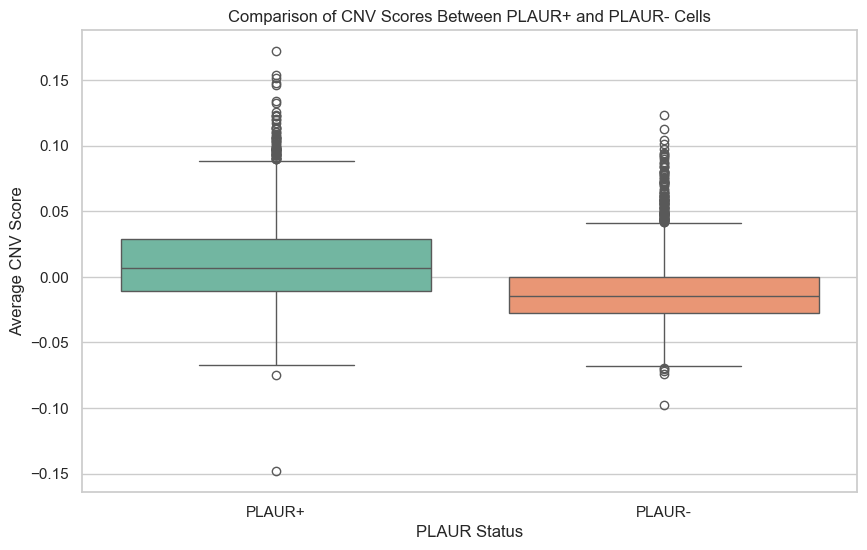

In [144]:
# Step 1: Create a new column in the DataFrame for PLAUR status labels
cnv_df_pca['PLAUR_Status'] = plaur_labels

# Step 2: Set plot style and figure size
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Step 3: Create a boxplot to visualize the distribution of CNV scores between PLAUR+ and PLAUR- cells
sns.boxplot(x='PLAUR_Status', y='Average_CNV_Score', data=cnv_df_pca, palette='Set2')

# Step 4: Add plot title and labels for clarity
plt.title('Comparison of CNV Scores Between PLAUR+ and PLAUR- Cells')
plt.xlabel('PLAUR Status')
plt.ylabel('Average CNV Score')

# Display the plot
plt.show()

# Understanding the Silhouette Score in Clustering

The **Silhouette Score** is a metric used to quantify how well-separated clusters are in a dataset. It provides insight into the cohesion and separation of clusters by measuring the similarity of each data point to its own cluster compared to other clusters.

- **Cohesion**: The Silhouette Score calculates how similar each point is to other points within the same cluster.
- **Separation**: It also measures the dissimilarity of each point to points in the nearest neighboring cluster.

### Interpretation:
- A high Silhouette Score (close to 1) indicates that points are well-matched to their own cluster and distinct from other clusters, suggesting well-separated clusters.
- A low or negative Silhouette Score implies that points are poorly matched to their own cluster and may be closer to points in a neighboring cluster, indicating potential overlap between clusters or poorly defined clustering.

This score provides a useful way to evaluate the quality of clustering results, helping to identify if the chosen number of clusters is appropriate for the data.


In [146]:
# Calculate Silhouette Score on PCA-reduced CNV data
silhouette_avg = silhouette_score(cnv_combined_pca, cluster_assignments)
print(f"\nSilhouette Score: {silhouette_avg:.3f}")


Silhouette Score: 0.530


# Interpretation of a Silhouette Score of 0.530

### Significance of the Score
- A Silhouette Score of **0.530** suggests moderate separation between the clusters of PLAUR+ and PLAUR- cells.
- In clustering tasks:
  - Scores above **0.5** indicate reasonable separation between clusters.
  - Scores closer to **0.7** or higher are generally considered strong.

With a score of **0.530**, there is some distinction between the CNV profiles of PLAUR+ and PLAUR- cells, although the separation is not exceptionally strong. This suggests that PLAUR expression is associated with differences in CNV patterns, but there may also be some overlap in CNV features between the two groups.

### Conclusion
- **Moderate Separation**: The Silhouette Score indicates that while PLAUR+ and PLAUR- cells show distinct CNV patterns, there is a moderate level of overlap. This may imply shared or similar CNV features between the two groups alongside distinct elements.
- **Biological Relevance**: The separation supports the hypothesis that PLAUR expression is associated with differential genomic features, although the overlap suggests that further investigation is warranted to understand the nature of these differences.

Thus, the moderate Silhouette Score of **0.530** provides evidence that PLAUR expression has some association with CNV variability. However, the results imply that PLAUR+ and PLAUR- cells might share certain genomic characteristics while differing in others, suggesting nuanced biological implications.
